In [1]:
%matplotlib notebook

In [37]:
import numpy as np
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns

from edward.models import (Bernoulli, Laplace, Normal, 
                           Empirical, PointMass)

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [3]:
plt.style.use('seaborn-notebook')
sns.set_context('notebook')
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [4]:
'TensorFlow version: ' + tf.__version__

'TensorFlow version: 1.4.0'

##### Constants

In [5]:
T = 10000  # HMC nbr. of samples
P = 1000  # Nbr. posterior (predictive) samples

seed = 8888
rng = np.random.RandomState(seed)

### Toy Dataset ("Moons")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    *make_moons(500, random_state=rng),
    test_size=.2,
    random_state=rng
)

In [7]:
N, D = X_train.shape 

<IPython.core.display.Javascript object>


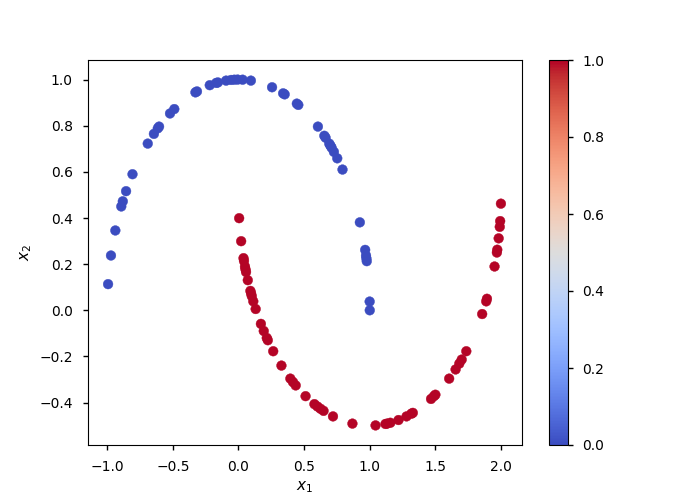

In [8]:
fig, ax = plt.subplots(figsize=(7, 5))

cb = ax.scatter(*X_test.T, c=y_test, cmap='coolwarm')
fig.colorbar(cb, ax=ax)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

## Gaussian Prior

### Model specification

In [9]:
X = tf.placeholder(tf.float32, [N, D])

w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros([]), scale=tf.ones([]))

y = Bernoulli(logits=ed.dot(X, w) + b)

### Inference

#### Maximum a posterior (MAP)

In [10]:
qw = PointMass(params=tf.Variable(tf.random_normal([D])))
qb = PointMass(params=tf.Variable(tf.random_normal([])))

In [11]:
inference = ed.MAP({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 113.618


In [12]:
w_map = qw.eval()
w_map

array([ 1.15, -4.49], dtype=float32)

In [13]:
b_map = qb.eval()
b_map

0.44861546

#### Hybrid Monte Carlo

In [14]:
qw = Empirical(params=tf.Variable(tf.random_normal([T, D])))
qb = Empirical(params=tf.Variable(tf.random_normal([T])))

In [15]:
inference = ed.HMC({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.initialize(n_print=10, step_size=0.15)

tf.global_variables_initializer().run()

for i in range(inference.n_iter):

    info_dict = inference.update()
    inference.print_progress(info_dict)
    
inference.finalize()

10000/10000 [100%] ██████████████████████████████ Elapsed: 21s | Acceptance Rate: 0.903


In [16]:
w1_min, w1_max = -.2, 2
w2_min, w2_max = -8, 1.

### Evaluation

<IPython.core.display.Javascript object>


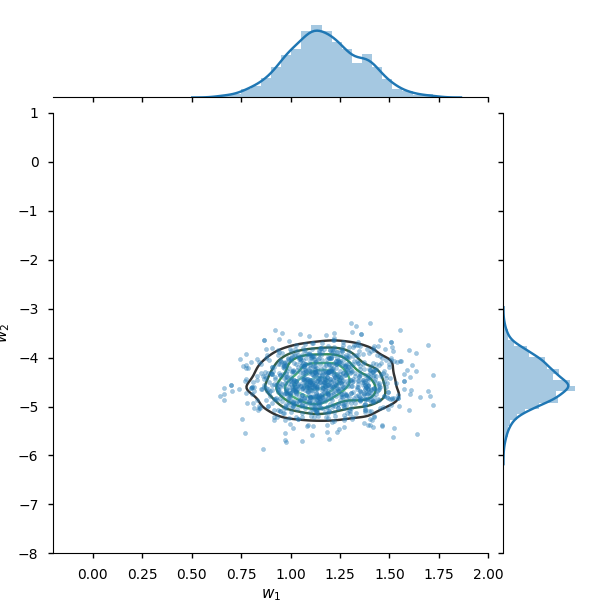

In [17]:
g = sns.JointGrid(*qw.sample(sample_shape=P).eval().T,
                  xlim=(w1_min, w1_max),
                  ylim=(w2_min, w2_max))
g = g.plot_joint(plt.scatter, s=3.**2, alpha=.4)
g = g.plot_joint(sns.kdeplot, zorder=0, n_levels=6)
g = g.plot_marginals(sns.distplot, kde=True)
g = g.set_axis_labels('$w_1$', '$w_2$')

## Laplace Prior

### Model specification

In [18]:
X = tf.placeholder(tf.float32, [N, D])

w = Laplace(loc=tf.zeros(D), scale=tf.ones(D))
b = Laplace(loc=tf.zeros([]), scale=tf.ones([]))

y = Bernoulli(logits=ed.dot(X, w) + b)

### Inference

#### Maximum a posterior (MAP)

In [19]:
qw = PointMass(params=tf.Variable(tf.random_normal([D])))
qb = PointMass(params=tf.Variable(tf.random_normal([])))

In [20]:
inference = ed.MAP({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 106.517


In [21]:
w_map = qw.eval()
w_map

array([ 1.17, -5.56], dtype=float32)

In [22]:
b_map = qb.eval()
b_map

0.68323755

#### Hybrid Monte Carlo

In [23]:
qw = Empirical(params=tf.Variable(tf.random_normal([T, D])))
qb = Empirical(params=tf.Variable(tf.random_normal([T])))

In [24]:
inference = ed.HMC({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.initialize(n_print=10, step_size=0.15)

tf.global_variables_initializer().run()

for i in range(inference.n_iter):

    info_dict = inference.update()
    inference.print_progress(info_dict)
    
inference.finalize()

10000/10000 [100%] ██████████████████████████████ Elapsed: 23s | Acceptance Rate: 0.910


### Evaluation

<IPython.core.display.Javascript object>


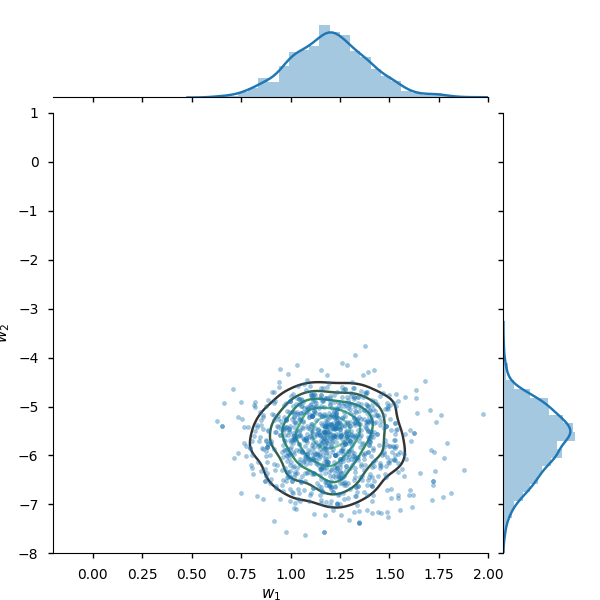

In [25]:
g = sns.JointGrid(*qw.sample(sample_shape=P).eval().T,
                  xlim=(w1_min, w1_max),
                  ylim=(w2_min, w2_max))
g = g.plot_joint(plt.scatter, s=3.**2, alpha=.4)
g = g.plot_joint(sns.kdeplot, zorder=0, n_levels=6)
g = g.plot_marginals(sns.distplot, kde=True)
g = g.set_axis_labels('$w_1$', '$w_2$')

## Spike-and-Slab Prior

### Model specification

In [26]:
X = tf.placeholder(tf.float32, [N, D])

w_mask = Bernoulli(logits=tf.zeros(D))
w_raw = Normal(loc=tf.zeros(D), scale=tf.ones(D))
w = tf.to_float(w_mask) * w_raw

b_mask = Bernoulli(logits=tf.zeros([]))
b_raw = Normal(loc=tf.zeros([]), scale=tf.ones([]))
b = tf.to_float(b_mask) * b_raw

y = Bernoulli(logits=ed.dot(X, w) + b)

### Inference

#### Maximum a posterior (MAP)

In [27]:
qw = PointMass(params=tf.Variable(tf.random_normal([D])))
qb = PointMass(params=tf.Variable(tf.random_normal([])))

In [28]:
inference = ed.MAP({w_raw: qw, b_raw: qb}, 
                   data={X: X_train, y: y_train})
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 286.974


In [29]:
w_map = qw.eval()
w_map

array([ 1.3 , -3.53], dtype=float32)

In [30]:
b_map = qb.eval()
b_map

-0.046046846

#### Hybrid Monte Carlo

In [31]:
qw = Empirical(params=tf.Variable(tf.random_normal([T, D])))
qb = Empirical(params=tf.Variable(tf.random_normal([T])))

In [32]:
inference = ed.HMC({w_raw: qw, b_raw: qb}, 
                   data={X: X_train, y: y_train})
inference.initialize(n_print=10, step_size=0.15)

tf.global_variables_initializer().run()

for i in range(inference.n_iter):

    info_dict = inference.update()
    inference.print_progress(info_dict)
    
inference.finalize()

10000/10000 [100%] ██████████████████████████████ Elapsed: 32s | Acceptance Rate: 0.416


### Evaluation

In [33]:
w_mask_samples = w_mask.sample(sample_shape=P).eval()
w_raw_samples = qw.sample(sample_shape=P).eval()
w_samples = w_mask_samples * w_raw_samples

<IPython.core.display.Javascript object>


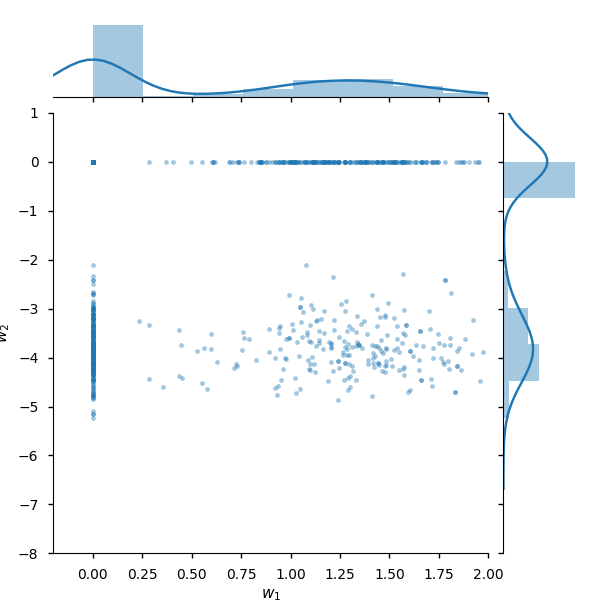

In [34]:
g = sns.JointGrid(*w_samples.T,
                  xlim=(w1_min, w1_max),
                  ylim=(w2_min, w2_max))
g = g.plot_joint(plt.scatter, s=3.**2, alpha=.4)
g = g.plot_marginals(sns.distplot, kde=True)
g = g.set_axis_labels('$w_1$', '$w_2$')

In [35]:
mixtures = np.right_shift(np.packbits(w_mask_samples, 
                                      axis=1), 6).flatten()

<IPython.core.display.Javascript object>


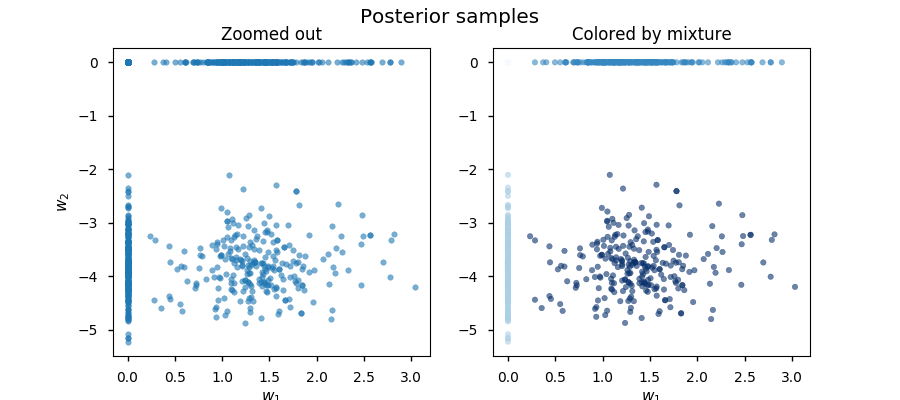

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

fig.suptitle('Posterior samples')

ax1.scatter(*w_samples.T, s=4.**2, alpha=.6)
ax2.scatter(*w_samples.T, c=mixtures, s=4.**2, alpha=.6, cmap='Blues')

ax1.set_title('Zoomed out')

ax1.set_xlabel('$w_1$')
ax1.set_ylabel('$w_2$')

ax2.set_title('Colored by mixture')

ax2.set_xlabel('$w_1$')

plt.show()